In [18]:
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

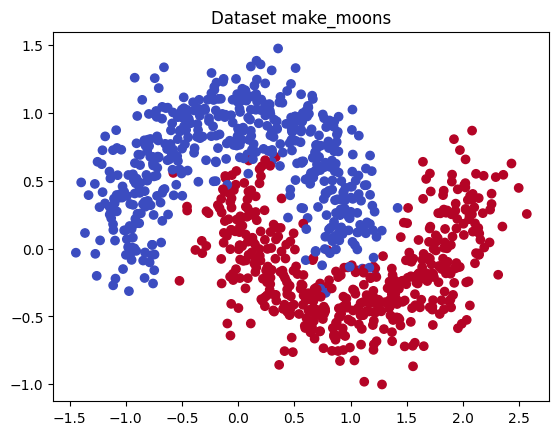

In [33]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.title("Dataset make_moons")
plt.show()

# Conversion en tenseurs PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # (N,1)

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
import torch.nn as nn

class MoonClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 16),   # entrée 2 -> 16 neurones
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),    # sortie 1 (binaire)
            #nn.Sigmoid()        # pour que la sortie soit entre 0 et 1 si on a nn.BCELoss()
        )

    def forward(self, x):
        return self.layers(x)

model = MoonClassifier()

# Device
try:
    device = next(model.parameters()).device
except StopIteration:
    device = torch.device("cpu")
model = model.to(device)        


In [35]:
# Binary Cross-Entropy pour binaire
criterion = nn.BCEWithLogitsLoss() 

# Optimiseur (Adam est efficace)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
def accuracy_fn(y_true, y_pred):
    y_pred_classes = (y_pred > 0.5).float()
    acc = (y_pred_classes == y_true).sum().item() / len(y_true)
    return acc * 100

epochs = 200
for epoch in range(epochs):
    # ---- TRAIN ----
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # ---- TEST ----
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # Affichage chaque 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | "
              f"Train Loss: {loss.item():.4f} | Train Acc: {acc:.2f}% | "
              f"Test Loss: {test_loss.item():.4f} | Test Acc: {test_acc:.2f}%")


Epoch 010 | Train Loss: 0.6060 | Train Acc: 76.38% | Test Loss: 0.6048 | Test Acc: 80.00%
Epoch 020 | Train Loss: 0.5162 | Train Acc: 81.25% | Test Loss: 0.5306 | Test Acc: 80.00%
Epoch 030 | Train Loss: 0.4383 | Train Acc: 85.38% | Test Loss: 0.4365 | Test Acc: 84.50%
Epoch 040 | Train Loss: 0.3657 | Train Acc: 87.88% | Test Loss: 0.3593 | Test Acc: 85.00%
Epoch 050 | Train Loss: 0.3029 | Train Acc: 88.75% | Test Loss: 0.2973 | Test Acc: 86.50%
Epoch 060 | Train Loss: 0.2625 | Train Acc: 89.00% | Test Loss: 0.2565 | Test Acc: 87.50%
Epoch 070 | Train Loss: 0.2324 | Train Acc: 91.12% | Test Loss: 0.2206 | Test Acc: 89.50%
Epoch 080 | Train Loss: 0.1934 | Train Acc: 92.62% | Test Loss: 0.1809 | Test Acc: 92.00%
Epoch 090 | Train Loss: 0.1520 | Train Acc: 95.00% | Test Loss: 0.1357 | Test Acc: 96.00%
Epoch 100 | Train Loss: 0.1220 | Train Acc: 96.50% | Test Loss: 0.1041 | Test Acc: 98.00%
Epoch 110 | Train Loss: 0.1016 | Train Acc: 96.75% | Test Loss: 0.0779 | Test Acc: 97.50%
Epoch 120 

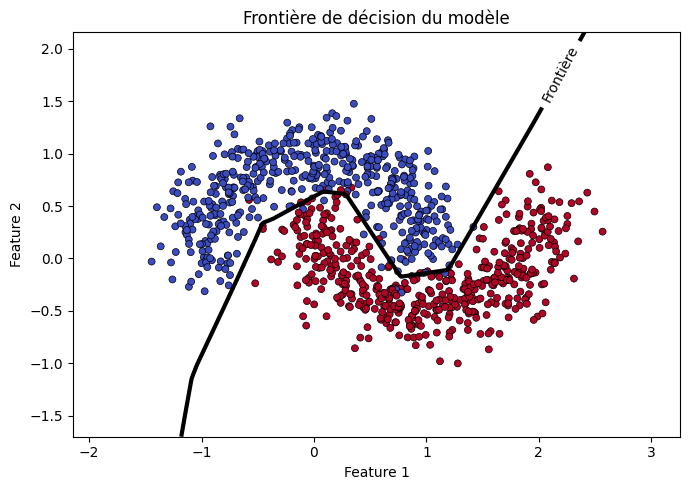

In [ ]:
# Pour tracer : on revient en coordonnées brutes des données
X_np = X.detach().cpu().numpy()
y_np = y.detach().cpu().numpy()

x_min, x_max = X[:, 0].min().item() - 0.7, X[:, 0].max().item() + 0.7
y_min, y_max = X[:, 1].min().item() - 0.7, X[:, 1].max().item() + 0.7

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_np = np.c_[xx.ravel(), yy.ravel()]

grid_t = torch.from_numpy(grid_np).float().to(device)

model.eval()
with torch.no_grad():
    out = model(grid_t)                     
    probs = torch.sigmoid(out.squeeze(-1))  
Z = probs.detach().cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(7, 5))
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap=plt.cm.coolwarm,
            s=25, edgecolors='k', linewidths=0.5)

# Courbe de frontière (isoprobe 0.5)
CS = plt.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=3)
try:
    plt.clabel(CS, inline=True, fmt={0.5: "Frontière"}, fontsize=10)
except Exception:
    pass

plt.title("Frontière de décision du modèle")
plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
plt.tight_layout()
plt.show()